In [1]:
import sys
sys.path.append("..")

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import importlib
import plotting
from functools import partial

In [3]:
# dummy loss function
def loss_fn(sharpness, w):
    return (sharpness/2)*w**2
    # return np.abs(w)**sharpness

In [294]:
# quadratic function

def sim_traj(params, loss_fn, mode='sgd', bias_correction=False, tol=1e-8):
    sharpness, eta, w0, n_eps = params['sharpness'], params['eta'], params['w0'], params['n_eps'], 
    rms_lim, rms_beta, rms_init = params['rms_lim'], params['rms_beta'], params['rms_init'],
    
    ws = [w0]
    w = w0
    partial_loss_fn = partial(loss_fn, sharpness)
    grad_fn = jax.jit(jax.grad(partial_loss_fn))
    hess_fn = jax.jit(jax.hessian(partial_loss_fn))
    losses = [partial_loss_fn(w)]
    
    rms = rms_init
    eps = 10**-8
    
    for i in range(n_eps):
        w_grad = grad_fn(w)
        bc = 1. if bias_correction else (1-rms_beta**(i+1))
        rms = rms_beta * rms + (1-rms_beta)*w_grad**2
        
        if mode == 'sgd':
            w_new = w - eta * w_grad
        elif mode == 'rms':
            w_new = w - eta * w_grad / np.sqrt(rms*bc+eps)
        elif mode == 'rms-lb':
            w_new = w - eta * w_grad / np.maximum(np.sqrt(rms*bc+eps), rms_lim)
        elif mode == 'rms-ub':
            w_new = w - eta * w_grad / np.minimum(np.sqrt(rms*bc+eps), rms_lim)
        if jnp.linalg.norm(w-w_new) < tol:
            break
            
        w = w_new
        losses.append(partial_loss_fn(w))
        ws.append(w)
        
    n_fills = n_eps+1 - len(ws)
    ws = ws + [ws[-1] for _ in range(n_fills)]
    losses = losses + [losses[-1] for _ in range(n_fills)]
    return np.array(ws), np.array(losses)


In [5]:
def viridis_xy(x, y):
    indices = np.arange(len(x) - 1)  # Segment indices
    norm = Normalize(vmin=indices.min(), vmax=indices.max())  # Normalize index range
    cmap = cm.viridis  # Use Viridis colormap
    
    # Create segments for LineCollection
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create the LineCollection, coloring based on index
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(indices)  # Use index order for coloring
    lc.set_linewidth(2)
    return lc

s 0 opt 0 w0:1.00E-01, w1:-1.30E-01, wf:+2.48E+10, elam2.0909090909090904
s 0 opt 1 w0:1.00E-01, w1:-3.06E+00, wf:+5.95E-01, elam2.0909090909090904
s 0 opt 2 w0:1.00E-01, w1:-1.09E-01, wf:+4.80E+00, elam2.090909090909091
s 0 opt 3 w0:1.00E-01, w1:-3.06E+00, wf:+2.10E+04, elam2.0909090909090904
s 1 opt 0 w0:1.00E-01, w1:-9.00E-02, wf:+2.66E-06, elam1.727272727272727
s 1 opt 1 w0:1.00E-01, w1:-3.06E+00, wf:+5.95E-01, elam1.727272727272727
s 1 opt 2 w0:1.00E-01, w1:-7.27E-02, wf:+1.48E-15, elam1.7272727272727273
s 1 opt 3 w0:1.00E-01, w1:-3.06E+00, wf:+4.89E-01, elam1.727272727272727


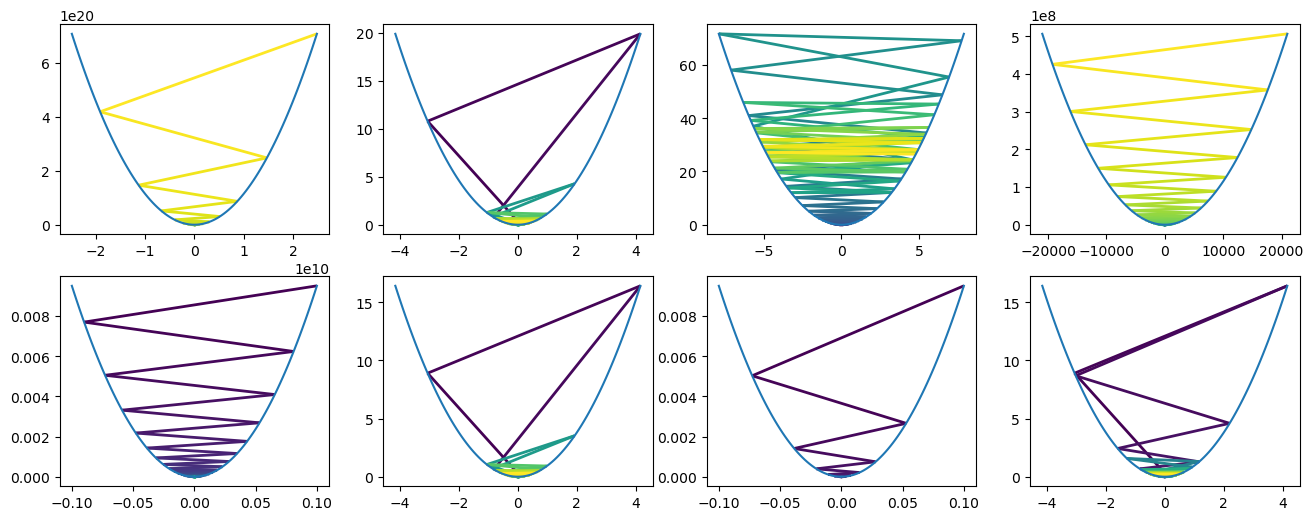

In [6]:

# loss_fn = lambda x: sharp/2*x**2

from matplotlib.collections import LineCollection
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# quadratic loss function L = \lambda/2 X^2
def loss_fn(sharpness, w):
    return (sharpness/2)*w**2

fig, axs = plt.subplots(2, 4, figsize=(16, 6))
all_ws = []
for i, sharpness in enumerate([2.3, 1.9]):
    for j, opt in enumerate(['sgd', 'rms', 'rms-lb', 'rms-ub']):
        # sharpness = 2.
        w0 = 0.1
        j_factor = 1 if j != 2 else 10
        params = {
            'eta': 1. * j_factor, 
            'sharpness': sharpness, 
            'rms_lim': 1.1 * j_factor,
            'rms_beta': 0.9,
            'rms_init': (sharpness*w0)**2,
            # 'rms_init': 0.,
            'w0': w0,
            'n_eps': 100,
        }
        
        ws, losses = sim_traj(params, mode=opt)
        lc = viridis_xy(ws, losses)
        all_ws.append(ws)

        axs[i][j].add_collection(lc)
        axs[i][j].autoscale_view()

        xmax = max(np.abs(ws))
        xs = np.linspace(-xmax, xmax, 101)
        ys = loss_fn(sharpness, xs)
        axs[i][j].plot(xs, ys)
        
        print("s", i, "opt", j, f"w0:{ws[0]:.2E}, w1:{ws[1]:+.2E}, wf:{ws[-1]:+.2E}, elam{params['eta']*sharpness/params['rms_lim']}")
        
plt.show()

In [7]:
loss_fn = lambda x0, x1 : (x1)**4*(x0)**4 # x0 first layer, x1 second layer


zs_l = np.array(loss_fn(np.ravel(X), np.ravel(Y)))
print(zs_l.shape)
zs_g = np.array(jax.vmap(jax.grad(loss_fn, argnums=[0, 1]))(np.ravel(X), np.ravel(Y)))
print(zs_g.shape)
zs_h = np.array(jax.vmap(jax.hessian(loss_fn, argnums=[0, 1]))(np.ravel(X), np.ravel(Y)))
print(zs_h.shape)


NameError: name 'X' is not defined

In [12]:

def loss_fn(sharpness, inputs):
    dim = len(inputs.shape)
    return np.product(inputs, axis=dim-1)**sharpness

# Sim the trajectories
colors = ['r','orange',  'green', 'blue']

# for i, sharpness in enumerate([2.1, 1.9]):
for i, sharpness in enumerate([2.0]):    
    all_ws = []
    all_losses = []
    for j, opt in enumerate(['sgd', 'rms', 'rms-lb', 'rms-ub']):
        
        w0 = np.array([0.1, 10.])

        params = {
            'eta': 0.011, 
            'sharpness': sharpness, 
            'rms_lim': 1.0,
            'rms_beta': 0.9,
            # 'rms_init': jax.grad(partial_loss_fn)(w0)**2,
            'rms_init': 0.,
            'w0': w0,
            'n_eps': 10,
        }
        
        ws, losses = sim_traj(params, mode=opt, bias_correction=True)
        all_ws.append(ws)
        all_losses.append(losses)

    all_ws = np.array(all_ws)
    all_losses = np.array(all_losses)

with np.printoptions(suppress=True, precision=2):
    print(all_ws)

[[[ 0.1  10.  ]
  [-0.12 10.  ]
  [ 0.14  9.99]
  [-0.17  9.99]
  [ 0.21  9.98]
  [-0.25  9.97]
  [ 0.29  9.96]
  [-0.35  9.94]
  [ 0.41  9.92]
  [-0.47  9.88]
  [ 0.54  9.83]]

 [[ 0.1  10.  ]
  [ 0.07  9.97]
  [ 0.05  9.95]
  [ 0.03  9.94]
  [ 0.02  9.94]
  [ 0.02  9.94]
  [ 0.01  9.94]
  [ 0.01  9.94]
  [ 0.    9.94]
  [ 0.    9.94]
  [ 0.    9.94]]

 [[ 0.1  10.  ]
  [ 0.07 10.  ]
  [ 0.05 10.  ]
  [ 0.03 10.  ]
  [ 0.02 10.  ]
  [ 0.02 10.  ]
  [ 0.01 10.  ]
  [ 0.01 10.  ]
  [ 0.   10.  ]
  [ 0.   10.  ]
  [ 0.   10.  ]]

 [[ 0.1  10.  ]
  [-0.12  9.97]
  [ 0.14  9.94]
  [-0.17  9.91]
  [ 0.19  9.88]
  [-0.22  9.86]
  [ 0.25  9.83]
  [-0.28  9.81]
  [ 0.32  9.79]
  [-0.35  9.76]
  [ 0.39  9.74]]]


-0.5418592691421509 0.4721616208553314 9.740498542785645 10.0
Grad, scaled by 36 for clarity
Eigvecs, scaled by 18 for clarity
[[-0.1        10.        ]
 [ 0.12        9.99779987]
 [-0.14388385  9.99463272]
 [ 0.1723209   9.99008083]
 [-0.20603338  9.98355484]
 [ 0.24575046  9.97423172]
 [-0.2921178   9.96097946]
 [ 0.34553578  9.94227982]
 [-0.40589276  9.9161644 ]
 [ 0.47216162  9.88022327]
 [-0.54185927  9.83176422]] 
 [ 1.          1.43936646  2.06803441  2.96356153  4.23102522  6.00824451
  8.4668169  11.8020649  16.19981575 21.76280785 28.38153839]
[[-1.00000000e-01  1.00000000e+01]
 [ 4.83239517e-02  9.98378181e+00]
 [ 3.24243307e-03  9.98089218e+00]
 [ 5.76307531e-04  9.98088074e+00]
 [ 1.32905087e-04  9.98088074e+00]
 [ 3.41300401e-05  9.98088074e+00]
 [ 9.13399890e-06  9.98088074e+00]
 [ 2.45141246e-06  9.98088074e+00]
 [ 6.42026976e-07  9.98088074e+00]
 [ 1.60384445e-07  9.98088074e+00]
 [ 3.73869966e-08  9.98088074e+00]] 
 [1.00000000e+00 2.32763588e-01 1.04732334e-03 3.30

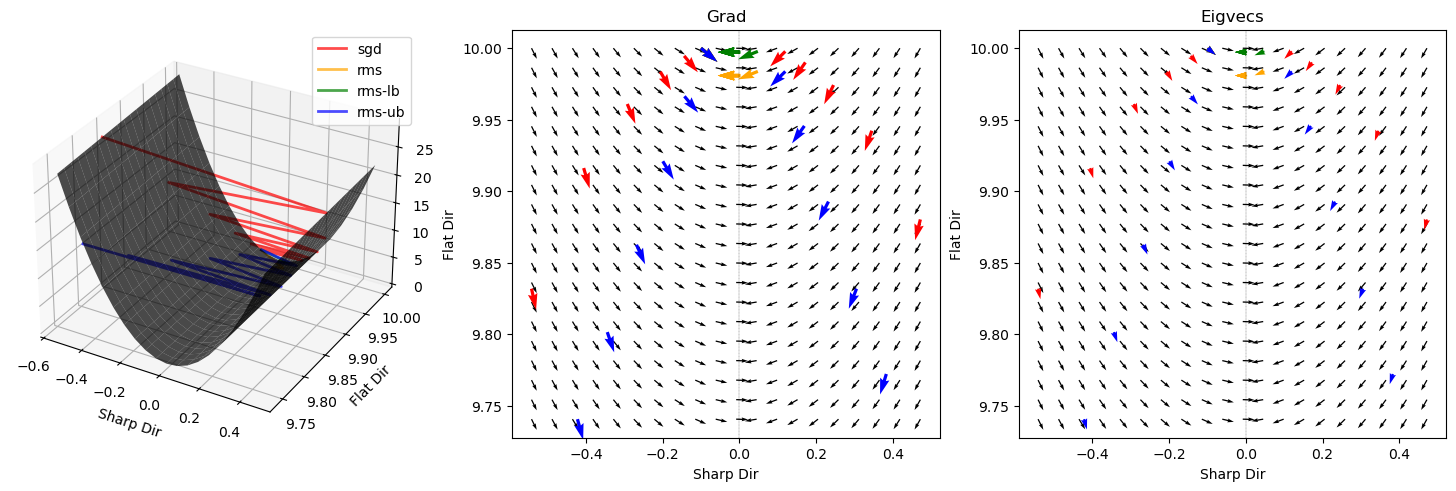

In [283]:
importlib.reload(plotting)

def loss_fn(sharpness, inputs):
    dim = len(inputs.shape)
    return np.product(inputs, axis=dim-1)**sharpness

# Sim the trajectories
colors = ['r','orange',  'green', 'blue']
opt_names = ['sgd', 'rms', 'rms-lb', 'rms-ub']

# for i, sharpness in enumerate([2.1, 1.9]):
for i, sharpness in enumerate([2.0]):    
    partial_loss_fn = partial(loss_fn, sharpness)

    all_ws = []
    all_losses = []
    for j, opt in enumerate(opt_names):
        
        w0 = np.array([-0.1, 10.])

        params = {
            'eta': 0.011 , 
            'sharpness': sharpness, 
            'rms_lim': 1.0,
            'rms_beta': 0.9,
            'rms_init': jax.grad(partial_loss_fn)(w0),
            # 'rms_init': 0.,
            'w0': w0,
            'n_eps': 10,
        }
        
        ws, losses = sim_traj(params, mode=opt)
        all_ws.append(ws)
        all_losses.append(losses)

    all_ws = np.array(all_ws)
    all_losses = np.array(all_losses)
    
    xmin, xmax = np.min(all_ws[:, :, 0]), np.max(all_ws[:, :, 0])
    ymin, ymax = np.min(all_ws[:, :, 1]), np.max(all_ws[:, :, 1])
    print(xmin, xmax, ymin, ymax)
    
    fig, axs = plotting.vis_landscape(partial_loss_fn, xmin=xmin, xmax=xmax, 
                                            ymin=ymin, ymax=ymax, 
                                            yscale=True)
    all_gs = []
    all_hs = []
    all_es = []
    
    for i in range(len(all_ws)):
        ws = all_ws[i]
        losses = all_losses[i]
        print(ws, "\n", losses)
        
        zs_g = np.array(jax.vmap(jax.grad(partial_loss_fn))(ws))
        all_gs.append(zs_g)

        zs_h = np.array(jax.vmap(jax.hessian(partial_loss_fn))(ws))
        all_hs.append(np.array(zs_h))
        s, v = jax.vmap(jnp.linalg.eigh)(zs_h)  # why was this transposed?
        all_es.append(np.array(v[:, :, 1]))
        
    #     sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    #     grad_scale = sharp_scale / flat_scale
        grad_scale = 83.
        scaled_grads = all_gs[i].copy()
        scaled_grads[:, 1] *= grad_scale
        scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]
        # scaled_grads *= np.sign(ws[:, 0])[:, np.newaxis]

        
    #     sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
    #     hess_scale = sharp_scale / flat_scale
        hess_scale = 41.
        scaled_hess = all_es[i].copy()
        scaled_hess[:, 1] *= hess_scale
        scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
        scaled_hess *= -np.sign(ws[:, 0])[:, np.newaxis]
    
        axs[0].plot(ws[:, 0], ws[:, 1], np.array(losses), c=colors[i], linewidth=2, label=opt_names[i], alpha=0.7, zorder=1)
        axs[1].quiver(ws[:, 0], ws[:, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], label=opt_names[i], scale=20.)
        axs[2].quiver(ws[:, 0], ws[:, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], label=opt_names[i], scale=40.)
    axs[0].legend()
    
    


(3, 2)
loss [101.999916  40.9987    45.27883 ]
grad [[   2.0199     19.795029]
 [  12.806046 -202.71228 ]
 [ -41.719517 -167.12297 ]]
eigv [array([-26.114254,  15.936126], dtype=float32), array([-13.733362,  24.590712], dtype=float32), array([-4826.714   ,    20.053001], dtype=float32)]
Grad, scaled by 0 for clarity
Eigvecs, scaled by 0 for clarity


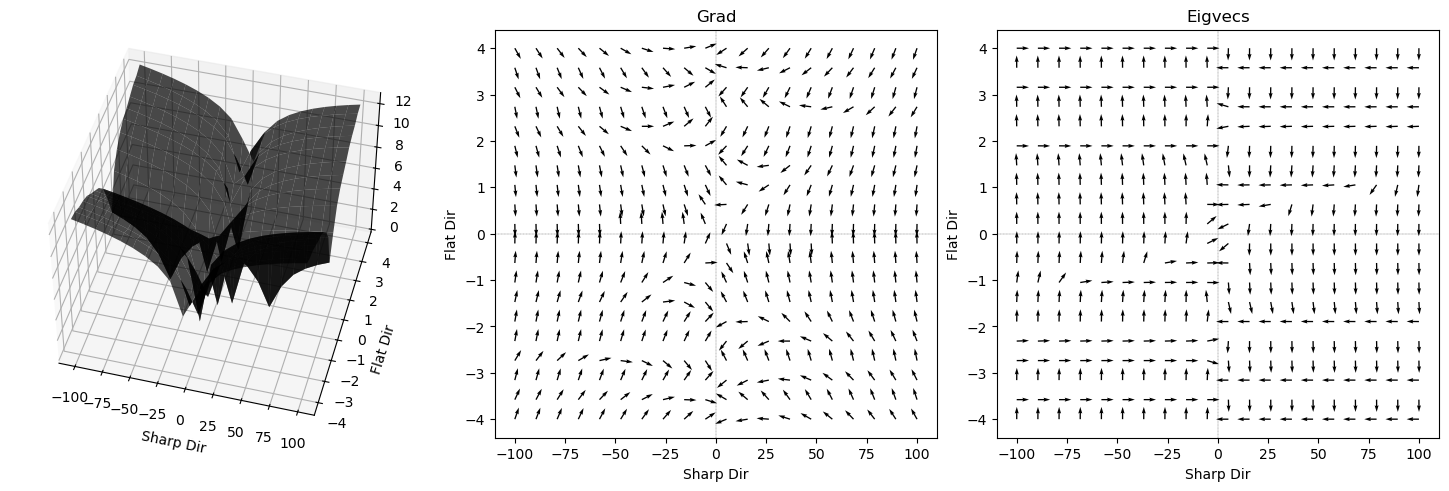

In [271]:
importlib.reload(plotting)

def loss_fn(sharpness, inputs):
    dim = len(inputs.shape)
    loss_func = lambda x: x[0]*x[1] + 10*jnp.cos(x[1]**2)
    
    return jnp.apply_along_axis(loss_func, dim-1, inputs)**2

# def loss_fn(sharpness, inputs):
#     dim = len(inputs.shape)
#     return np.product(inputs, axis=dim-1)**sharpness + 1
    

partial_loss_fn = partial(loss_fn, 2.)
x_try = np.array([[1., 0.1], [1., 1.], [1., 3.1]])

print(x_try.shape)
print("loss", partial_loss_fn(x_try))
grads = np.array([np.array(jax.grad(partial_loss_fn)(x_row)) for x_row in x_try])
print("grad", grads)
hessians = np.array([np.array(jax.hessian(partial_loss_fn)(x_row)) for x_row in x_try])
ss, vs = [], []
for hess in hessians:
    s, v = jnp.linalg.eigh(hess)
    ss.append(np.array(s))
    vs.append(np.array(v))
print("eigv", ss)

xscale = 100.
yscale = 4.
fig, axs = plotting.vis_landscape(partial_loss_fn, xmin=-xscale, xmax=xscale, 
                                            ymin=-yscale, ymax=yscale, 
                                            yscale=True, scale_fn=lambda x: np.arcsinh(x))
axs[0].view_init(elev=45, azim=-75)
plt.show()


4067.0264


ws (1001, 2) 
 [[ 0.1        10.        ]
 [-0.18869567  7.07340145]
 [-0.36686629  6.25719547]
 [-0.34576455  5.83682919]
 [-0.15583758  4.04143286]] 
 [[0.21385503 1.2640537 ]
 [0.21385501 1.26405394]
 [0.21385503 1.2640537 ]
 [0.21385501 1.26405394]
 [0.21385503 1.2640537 ]]
ws (1001, 2) 
 [[ 0.1        10.        ]
 [ 0.085       9.98499966]
 [ 0.07804816  9.97661018]
 [ 0.07366209  9.9711237 ]
 [ 0.07049374  9.96713448]] 
 [[0.0527107  9.94523621]
 [0.0527107  9.94523621]
 [0.0527107  9.94523621]
 [0.0527107  9.94523621]
 [0.0527107  9.94523621]]
ws (1001, 2) 
 [[ 0.1        10.        ]
 [ 0.085       9.98499966]
 [ 0.07804816  9.97661018]
 [ 0.07366209  9.9711237 ]
 [ 0.07049374  9.96713448]] 
 [[0.0527107  9.94523621]
 [0.0527107  9.94523621]
 [0.0527107  9.94523621]
 [0.0527107  9.94523621]
 [0.0527107  9.94523621]]
ws (1001, 2) 
 [[ 0.1        10.        ]
 [-0.22077298  6.74822426]
 [-0.19053602  6.14256001]
 [-0.37121993  6.26354027]
 [-0.33060014  5.4493227 ]] 
 [[-0.23421

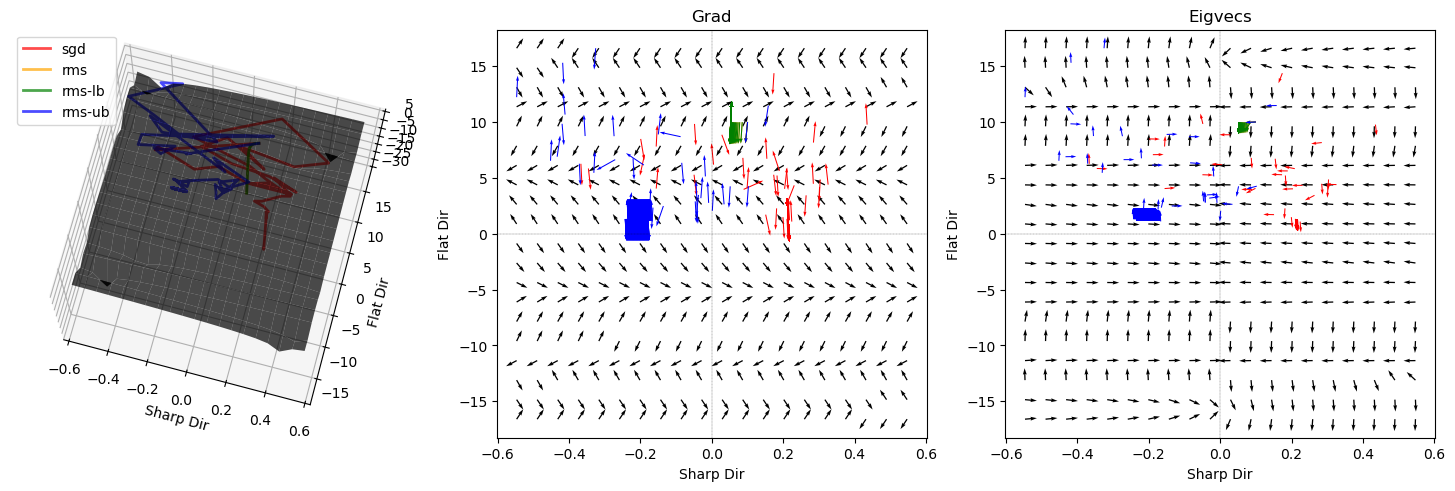

In [317]:
importlib.reload(plotting)

# def loss_fn(sharpness, inputs):
#     dim = len(inputs.shape)
#     return np.product(inputs, axis=dim-1)**sharpness + 1 - cos
    
    # loss_func = lambda x: x[0]**2*((x[1]-3)*(x[1]))
    # loss_func = lambda x: x[0]*(jnp.sqrt(jnp.abs((x[1]-3))*jnp.abs((x[1]))))
    # return jnp.apply_along_axis(loss_func, dim-1, inputs)**2

def loss_fn(sharpness, inputs):
    dim = len(inputs.shape)
    loss_func = lambda x: x[0]*x[1] + 10*jnp.cos(x[1]**2)
    
    return jnp.apply_along_axis(loss_func, dim-1, inputs)**2

# Sim the trajectories
colors = ['r','orange',  'green', 'blue']
opt_names = ['sgd', 'rms', 'rms-lb', 'rms-ub']
scale_fn = lambda x: jnp.log(x)

# for i, sharpness in enumerate([2.1, 1.9]):
for i, sharpness in enumerate([2.0]):    
    partial_loss_fn = partial(loss_fn, sharpness)

    all_ws = []
    all_losses = []
    for j, opt in enumerate(opt_names):
        
        w0 = np.array([0.1, 10.])

        params = {
            'eta': 0.0015, 
            'sharpness': sharpness, 
            'rms_lim': 0.9,
            'rms_beta': 0.9,
            # 'rms_init': jax.grad(partial_loss_fn)(w0)**2,
            'rms_init': 0.,
            'w0': w0,
            'n_eps': 1000,
        }
        
        ws, losses = sim_traj(params, loss_fn, mode=opt)
        print("ws", ws.shape, "\n", ws[:5], "\n", ws[-5:])
        # print("ws\n", ws)
        all_ws.append(ws)
        all_losses.append(losses)

    all_ws = np.array(all_ws)
    all_losses = np.array(all_losses)
    print("losses", [all_losses[i][-1] for i in range(len(all_losses))])
    
    xmin, xmax = np.min(all_ws[:, :, 0]), np.max(all_ws[:, :, 0])
    ymin, ymax = np.min(all_ws[:, :, 1]), np.max(all_ws[:, :, 1])
    print(xmin, xmax, ymin, ymax)
    xmx = max(np.abs(xmin), np.abs(xmax))
    ymx = max(np.abs(ymin), np.abs(ymax))
    
    
    # fig, axs = plotting.vis_landscape(partial_loss_fn, xmin=xmin, xmax=xmax, 
    #                                         ymin=ymin, ymax=ymax, 
    #                                         yscale=True, scale_fn=lambda x: np.arcsinh(x))
    fig, axs = plotting.vis_landscape(partial_loss_fn, xmin=-xmx, xmax=xmx, 
                                            ymin=-ymx, ymax=ymx, 
                                            yscale=True, scale_fn=scale_fn)
    
    all_gs = []
    all_hs = []
    all_es = []
    all_sharps = []
    
    for i in range(len(all_ws)):
        ws = all_ws[i]
        losses = all_losses[i]
        # print(ws, "\n")
        
        zs_g = np.array(jax.vmap(jax.grad(partial_loss_fn))(ws))
        all_gs.append(zs_g)

        zs_h = np.array(jax.vmap(jax.hessian(partial_loss_fn))(ws))
        all_hs.append(np.array(zs_h))
        s, v = jax.vmap(jnp.linalg.eigh)(zs_h) 
        all_es.append(np.array(v[:, :, 1]))
        all_sharps.append(s[-1, -1])
        
    #     sharp_scale, flat_scale = np.mean(np.abs(all_gs[-1]), axis=0)
    #     grad_scale = sharp_scale / flat_scale
        grad_scale = 1.
        scaled_grads = all_gs[i].copy()
        scaled_grads[:, 1] *= grad_scale
        scaled_grads /= np.linalg.norm(scaled_grads, axis=1)[:, np.newaxis]
        # scaled_grads *= np.sign(ws[:, 0])[:, np.newaxis]

        
    #     sharp_scale, flat_scale = np.mean(np.abs(all_es[-1]), axis=0)
    #     hess_scale = sharp_scale / flat_scale
        hess_scale = 1.
        scaled_hess = all_es[i].copy()
        scaled_hess[:, 1] *= hess_scale
        scaled_hess /= np.linalg.norm(scaled_hess, axis=1)[:, np.newaxis]
        scaled_hess *= -np.sign(ws[:, 0])[:, np.newaxis]
    
        axs[0].plot(ws[:, 0], ws[:, 1], scale_fn(np.array(losses)), c=colors[i], linewidth=2, label=opt_names[i], alpha=0.7, zorder=1)
        axs[1].quiver(ws[:, 0], ws[:, 1], -scaled_grads[:, 0], -scaled_grads[:, 1], color=colors[i], label=opt_names[i], scale=20.)
        axs[2].quiver(ws[:, 0], ws[:, 1], scaled_hess[:, 0], scaled_hess[:, 1], color=colors[i], label=opt_names[i], scale=40.)
        
    axs[0].legend()

print("sharps", all_sharps)
axs[0].view_init(elev=75, azim=-75)
# ax_l.view_init(elev=30, azim=45
plt.show()
